# Parcial 1 Procesamiento de datos

## Pontificia Universidad Javeriana

### Autores: Tomas Alejandro Silva Correal, Juan Guillermo Pabón Vargas

#### Fecha: 3 de Septiembre de 2025



## **Problematica**

Hemos sido contratados por una compañía de fútbol para la creación de un nuevo
equipo de fútbol en la liga inglesa. Se tiene el interés de conocer un poco más los
equipos y resultados que se obtuvieron en la liga de 17-18, para así poder tener una
mejor idea de que tipos de jugadores se preferiría contratar y que estilo de juego
se desea para su equipo. 

Para esto contamos con la información de los
resultados por partido, como también estadísticas obtenidas por los equipos y
jugadores; todo lo anterior en sistema de ficheros distribuidos de hadoop (HDFS).

## **Objetivo**

Implementar modelos de predicción utilizando la biblioteca de aprendizaje automático MLlib PySpark.

## **Introducción**
En este parcial se va usar modelos de prediccion para procesamiento con alto volumen de datos, con el fin de analizar los datos y estadisticas de cada equipo en en liga 17-18 para poder tener mejor conocimento sobre los equipos y jugadores para poder crear un nuevo equipo de futbol


**#1 - Se importan las librerias**

In [0]:
%pip install geopandas

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# Importacioón de lirerias iniciales
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import json

#Se importan bibliotecas especializadas
from pylab import *

In [0]:
#Bibliotecas de Contexto PySpark iniciales y contexto para levantar la sesión de PYSPARK
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.types import(StructType,StructField,StringType,MapType)
import pyspark.sql.functions as sqlfun #Acceso a todas las funciones de sql

In [0]:
# Se crea una sesión para el contexto de procesamiento en la cuota
from pyspark import SparkConf 


# Se crea la sesión spark con la configuración creada
sparkParcial = (SparkSession.builder.appName("Parcial1_Silva-Vargas").config("spark.scheduler.mode", "FAIR").getOrCreate())

print("Sesión de Cluster: Parcial1_Silva-Vargas 03/09/25")

sparkParcial


Sesión de Cluster: Parcial1_Silva-Vargas 03/09/25


### **Se cargan los datos en los ficheros tipo CSV y JSON**

In [0]:
## Se carga el CSV de resultados 

###Se empieza a cargar en un objeto dataframe del tipo SPARK los datos CSV de los resultados
dfpresultados0 = sparkParcial.read.format("csv").option("header", "true").load("/Volumes/workspace/default/csv/resultados_futbol.csv")

# Se observan los primeros 6 elementos de este csv
dfpresultados0.show(6)

+-------+--------------------+-----------+--------------+----+----+---+----+----+---+-------+---+---+---+---+---+---+---+---+---+---+---+---+
| Season|            DateTime|   HomeTeam|      AwayTeam|FTHG|FTAG|FTR|HTHG|HTAG|HTR|Referee| HS| AS|HST|AST| HC| AC| HF| AF| HY| AY| HR| AR|
+-------+--------------------+-----------+--------------+----+----+---+----+----+---+-------+---+---+---+---+---+---+---+---+---+---+---+---+
|1993-94|1993-08-14T00:00:00Z|    Arsenal|      Coventry|   0|   3|  A|  NA|  NA| NA|     NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA|
|1993-94|1993-08-14T00:00:00Z|Aston Villa|           QPR|   4|   1|  H|  NA|  NA| NA|     NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA|
|1993-94|1993-08-14T00:00:00Z|    Chelsea|     Blackburn|   1|   2|  A|  NA|  NA| NA|     NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA|
|1993-94|1993-08-14T00:00:00Z|  Liverpool|Sheffield Weds|   2|   0|  H|  NA|  NA| NA|     NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA|
|1993-

In [0]:
### Se carga el CSV de jugadores 

#Se empieza a cargar en un objeto dataframe del tipo SPARK los datos CSV de los jugadores
dfpjugadores0 = sparkParcial.read.format("csv").option("header", "true").load("/Volumes/workspace/default/csv/jugadores.csv")

# Se observan los primeros 6 elementos de este csv
dfpjugadores0.show(6)

+-----------------+-------+---+--------+------------+------------+----------+---------+-------+----------+------+--------------+-----------+-------+-------+--------+-----------+
|             name|   club|age|position|position_cat|market_value|page_views|fpl_value|fpl_sel|fpl_points|region|   nationality|new_foreign|age_cat|club_id|big_club|new_signing|
+-----------------+-------+---+--------+------------+------------+----------+---------+-------+----------+------+--------------+-----------+-------+-------+--------+-----------+
|   Alexis Sanchez|Arsenal| 28|      LW|           1|          65|      4329|       12| 17.10%|       264|     3|         Chile|          0|      4|      1|       1|          0|
|       Mesut Ozil|Arsenal| 28|      AM|           1|          50|      4395|      9.5|  5.60%|       167|     2|       Germany|          0|      4|      1|       1|          0|
|        Petr Cech|Arsenal| 35|      GK|           4|           7|      1529|      5.5|  5.90%|       134|    

In [0]:
### Despues de convertir el fichero JSON temporadas en dos CSVs llamados temporadasJSON.csv y JugadoresJSON.csv, se cargan los CSVs

#Se empieza a cargar en un objeto dataframe del tipo SPARK los datos CSV de las temporadas
dfptemporadas0 = sparkParcial.read.format("csv").option("header", "true").load("/Volumes/workspace/default/csv/temporadasJSON.csv")


#Se empieza a cargar en un objeto dataframe del tipo SPARK los datos CSV de los jugadores
dfpjugadorestemporadas0 = sparkParcial.read.format("csv").option("header", "true").load("/Volumes/workspace/default/csv/JugadoresJSON.csv")

In [0]:
# Se muestran las columnas de los resultados
dfpresultados0.columns

['Season',
 'DateTime',
 'HomeTeam',
 'AwayTeam',
 'FTHG',
 'FTAG',
 'FTR',
 'HTHG',
 'HTAG',
 'HTR',
 'Referee',
 'HS',
 'AS',
 'HST',
 'AST',
 'HC',
 'AC',
 'HF',
 'AF',
 'HY',
 'AY',
 'HR',
 'AR']

In [0]:
# Se muestran las columnas de los jugadores
dfpjugadores0.columns

['name',
 'club',
 'age',
 'position',
 'position_cat',
 'market_value',
 'page_views',
 'fpl_value',
 'fpl_sel',
 'fpl_points',
 'region',
 'nationality',
 'new_foreign',
 'age_cat',
 'club_id',
 'big_club',
 'new_signing']

In [0]:
### Se muestran valores de archivos CSV como analisis preliminares
# Resultados
for valor in dfpresultados0.columns:
    dfpresultados0.describe([valor]).show()


+-------+-------+
|summary| Season|
+-------+-------+
|  count|  11113|
|   mean|   NULL|
| stddev|   NULL|
|    min|1993-94|
|    max|2021-22|
+-------+-------+

+-------+--------------------+
|summary|            DateTime|
+-------+--------------------+
|  count|               11113|
|   mean|                NULL|
| stddev|                NULL|
|    min|1993-08-14T00:00:00Z|
|    max|2022-04-10T16:30:00Z|
+-------+--------------------+

+-------+--------+
|summary|HomeTeam|
+-------+--------+
|  count|   11113|
|   mean|    NULL|
| stddev|    NULL|
|    min| Arsenal|
|    max|  Wolves|
+-------+--------+

+-------+--------+
|summary|AwayTeam|
+-------+--------+
|  count|   11113|
|   mean|    NULL|
| stddev|    NULL|
|    min| Arsenal|
|    max|  Wolves|
+-------+--------+

+-------+------------------+
|summary|              FTHG|
+-------+------------------+
|  count|             11113|
|   mean| 1.518221902276613|
| stddev|1.3019811033373492|
|    min|                 0|
|    max| 

In [0]:
# Se muestra resumen de valores para Jugadores
for valor in dfpjugadores0.columns:
    dfpjugadores0.describe([valor]).show()


+-------+------------------+
|summary|              name|
+-------+------------------+
|  count|               461|
|   mean|              NULL|
| stddev|              NULL|
|    min|   Aaron Cresswell|
|    max|Åukasz FabiaÅ„ski|
+-------+------------------+

+-------+--------+
|summary|    club|
+-------+--------+
|  count|     461|
|   mean|    NULL|
| stddev|    NULL|
|    min| Arsenal|
|    max|West+Ham|
+-------+--------+

+-------+-----------------+
|summary|              age|
+-------+-----------------+
|  count|              461|
|   mean|26.80477223427332|
| stddev| 3.96189170370961|
|    min|               17|
|    max|               38|
+-------+-----------------+

+-------+--------+
|summary|position|
+-------+--------+
|  count|     461|
|   mean|    NULL|
| stddev|    NULL|
|    min|      AM|
|    max|      SS|
+-------+--------+

+-------+------------------+
|summary|      position_cat|
+-------+------------------+
|  count|               461|
|   mean| 2.1800433839479

In [0]:
# Se muestra resumen de valores para temporadas
for valor in dfptemporadas0.columns:
    dfptemporadas0.describe([valor]).show()

+-------+------------------+
|summary|          match_id|
+-------+------------------+
|  count|               760|
|   mean|         1190363.5|
| stddev|109.76841114055298|
|    min|           1190174|
|    max|           1190553|
+-------+------------------+

+-------+-----------------+
|summary|          team_id|
+-------+-----------------+
|  count|              760|
|   mean|            93.05|
| stddev|81.87226224691857|
|    min|               13|
|    max|               96|
+-------+-----------------+

+-------+---------+
|summary|team_name|
+-------+---------+
|  count|      760|
|   mean|     NULL|
| stddev|     NULL|
|    min|  Arsenal|
|    max| West Ham|
+-------+---------+

+-------+----+
|summary|team|
+-------+----+
|  count| 760|
|   mean|NULL|
| stddev|NULL|
|    min|   L|
|    max|   V|
+-------+----+

+-------+-------------------+
|summary|        team_rating|
+-------+-------------------+
|  count|                760|
|   mean|  6.779921467786607|
| stddev|0.3776833

In [0]:
# Se muestra resumen de valores para Jugadores por temporadas
for valor in dfpjugadorestemporadas0.columns:
    dfpjugadorestemporadas0.describe([valor]).show()

+-------+------------------+
|summary|             match|
+-------+------------------+
|  count|             13675|
|   mean| 1190363.506252285|
| stddev|109.71307940913249|
|    min|           1190174|
|    max|           1190553|
+-------+------------------+

+-------+-----------------+
|summary|             team|
+-------+-----------------+
|  count|            13675|
|   mean|93.04387568555758|
| stddev|81.82597092854478|
|    min|               13|
|    max|               96|
+-------+-----------------+

+-------+-----------------+
|summary|        player_id|
+-------+-----------------+
|  count|            13675|
|   mean|87801.52987202925|
| stddev|81854.63725526667|
|    min|           100008|
|    max|            99487|
+-------+-----------------+

+-------+---------------+
|summary|    player_name|
+-------+---------------+
|  count|          13675|
|   mean|           NULL|
| stddev|           NULL|
|    min|Aaron Cresswell|
|    max|  Álvaro Morata|
+-------+---------------

In [0]:
### Se muestra la cantidad de valores nulos o imposibles en dfpresultados0
dfpresultados0.select(*[
    (
        sqlfun.count(sqlfun.when((sqlfun.isnan(c) | sqlfun.col(c).isNull()), c)) if t not in ("string")
        else sqlfun.count(sqlfun.when(sqlfun.col(c).isNull(), c))
    ).alias(c)
    for c, t in dfpresultados0.dtypes if c in dfpresultados0.columns
]).show()

+------+--------+--------+--------+----+----+---+----+----+---+-------+---+---+---+---+---+---+---+---+---+---+---+---+
|Season|DateTime|HomeTeam|AwayTeam|FTHG|FTAG|FTR|HTHG|HTAG|HTR|Referee| HS| AS|HST|AST| HC| AC| HF| AF| HY| AY| HR| AR|
+------+--------+--------+--------+----+----+---+----+----+---+-------+---+---+---+---+---+---+---+---+---+---+---+---+
|     0|       0|       0|       0|   0|   0|  0|   0|   0|  0|      0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|
+------+--------+--------+--------+----+----+---+----+----+---+-------+---+---+---+---+---+---+---+---+---+---+---+---+



In [0]:
# Cantidad de valores nulos o imposibles en dfpjugadores0
dfpjugadores0.select(*[
    (
        sqlfun.count(sqlfun.when((sqlfun.isnan(c) | sqlfun.col(c).isNull()), c)) if t not in ("string")
        else sqlfun.count(sqlfun.when(sqlfun.col(c).isNull(), c))
    ).alias(c)
    for c, t in dfpjugadores0.dtypes if c in dfpjugadores0.columns
]).show()

+----+----+---+--------+------------+------------+----------+---------+-------+----------+------+-----------+-----------+-------+-------+--------+-----------+
|name|club|age|position|position_cat|market_value|page_views|fpl_value|fpl_sel|fpl_points|region|nationality|new_foreign|age_cat|club_id|big_club|new_signing|
+----+----+---+--------+------------+------------+----------+---------+-------+----------+------+-----------+-----------+-------+-------+--------+-----------+
|   0|   0|  0|       0|           0|           0|         0|        0|      0|         0|     0|          0|          0|      0|      0|       0|          0|
+----+----+---+--------+------------+------------+----------+---------+-------+----------+------+-----------+-----------+-------+-------+--------+-----------+



In [0]:
#Cantidad de valores nulos o imposibles en dfpjugadores0
dfptemporadas0.select(*[
    (
        sqlfun.count(sqlfun.when((sqlfun.isnan(c) | sqlfun.col(c).isNull()), c)) if t not in ("string")
        else sqlfun.count(sqlfun.when(sqlfun.col(c).isNull(), c))
    ).alias(c)
    for c, t in dfptemporadas0.dtypes if c in dfptemporadas0.columns
]).show(vertical = True)

-RECORD 0--------------------
 match_id              | 0   
 team_id               | 0   
 team_name             | 0   
 team                  | 0   
 team_rating           | 0   
 date                  | 0   
 won_corners           | 16  
 att_sv_low_centre     | 269 
 won_contest           | 0   
 total_tackle          | 0   
 aerial_lost           | 0   
 possession_percentage | 0   
 accurate_pass         | 0   
 total_pass            | 0   
 total_throws          | 0   
 shot_off_target       | 11  
 total_offside         | 134 
 blocked_scoring_att   | 69  
 ontarget_scoring_att  | 27  
 aerial_won            | 0   
 att_miss_left         | 210 
 total_scoring_att     | 1   
 fk_foul_lost          | 0   
 att_miss_right        | 215 
 att_goal_low_left     | 526 
 att_goal_low_right    | 528 
 att_sv_low_left       | 419 
 goals                 | 226 
 att_pen_goal          | 706 
 att_sv_high_centre    | 587 
 att_goal_low_centre   | 604 
 att_miss_high         | 290 
 att_post_

In [0]:
# Cantidad de valores nulos o imposibles en dfpjugadorestemporadas0
dfpjugadorestemporadas0.select(*[
    (
        sqlfun.count(sqlfun.when((sqlfun.isnan(c) | sqlfun.col(c).isNull()), c)) if t not in ("string")
        else sqlfun.count(sqlfun.when(sqlfun.col(c).isNull(), c))
    ).alias(c)
    for c, t in dfpjugadorestemporadas0.dtypes if c in dfpjugadorestemporadas0.columns
]).show(vertical = True)

-RECORD 0----------------------
 match                 | 0     
 team                  | 0     
 player_id             | 0     
 player_name           | 0     
 player_position_value | 0     
 player_position_info  | 0     
 player_rating         | 0     
 good_high_claim       | 13330 
 touches               | 3276  
 saves                 | 12974 
 total_pass            | 3326  
 formation_place       | 0     
 accurate_pass         | 3399  
 aerial_won            | 7836  
 aerial_lost           | 7494  
 fouls                 | 8651  
 total_scoring_att     | 8718  
 total_tackle          | 7684  
 won_contest           | 9619  
 penalty_conceded      | 13595 
 blocked_scoring_att   | 11671 
 man_of_the_match      | 13295 
 goals                 | 12791 
 att_pen_goal          | 13619 
 goal_assist           | 12999 
 six_yard_block        | 13463 
 yellow_card           | 12512 
 error_lead_to_goal    | 13542 
 post_scoring_att      | 13530 
 second_yellow         | 13657 
 red_car

**Se puede evidenciar que solo los ficheros: resultados y de jugadores, no contienen valores nulos o imposibles. Temporadas y jugadores por temporada, contienen valores nulos dado que varias de las columnas no se aplican a ciertos tipos de jugadores o equipos.
Aun así, no se decidió eliminar las filas con valores nulos por que eso eliminaría muchos datos que son importantes para las visualizaciones de desempeño por cada tipo de jugador y de equipo**

In [0]:
#se crea una vista de resultados para ser usada en visualizaciones
dfpresultados0.createOrReplaceTempView("dfpresultados0_sql")

In [0]:
#Se selecciona las filas donde ninguna de las columnas contengan valores nulos para dfpresultados1
dfpresultados1 = sparkParcial.sql('''Select * from dfpresultados0_sql where Season is not null and DateTime is not null and
 HomeTeam is not null and  AwayTeam is not null and  FTHG is not null and  FTAG is not null and
 FTR is not null and  HTHG is not null and  HTAG is not null and  HTR is not null and
 Referee is not null and  HS is not null and  AS is not null and  HST is not null and
 AST is not null and  HC is not null and  AC is not null and
 HF is not null and  AF is not null and  HY is not null and  AY is not null and
 HR is not null and  AR is not null''')



In [0]:
#se verifica la cantidad de valores nulos o imposibles en dfpresultados1
dfpresultados1.select(*[
    (
        sqlfun.count(sqlfun.when((sqlfun.isnan(c) | sqlfun.col(c).isNull()), c)) if t not in ("string")
        else sqlfun.count(sqlfun.when(sqlfun.col(c).isNull(), c))
    ).alias(c)
    for c, t in dfpresultados1.dtypes if c in dfpresultados1.columns
]).show()

+------+--------+--------+--------+----+----+---+----+----+---+-------+---+---+---+---+---+---+---+---+---+---+---+---+
|Season|DateTime|HomeTeam|AwayTeam|FTHG|FTAG|FTR|HTHG|HTAG|HTR|Referee| HS| AS|HST|AST| HC| AC| HF| AF| HY| AY| HR| AR|
+------+--------+--------+--------+----+----+---+----+----+---+-------+---+---+---+---+---+---+---+---+---+---+---+---+
|     0|       0|       0|       0|   0|   0|  0|   0|   0|  0|      0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|
+------+--------+--------+--------+----+----+---+----+----+---+-------+---+---+---+---+---+---+---+---+---+---+---+---+



In [0]:
#se crea una vista de jugadores para ser usada en visualizaciones
dfpjugadores0.createOrReplaceTempView("dfpjugadores0_sql")

In [0]:
#Se selecciona las filas donde ninguna de las columnas contengan valores nulos para dfpjugadores1
dfpjugadores1 = sparkParcial.sql('''Select * from dfpjugadores0_sql where name is not null and club is not null and 
 age is not null and  position is not null and  position_cat is not null and  market_value is not null and
 page_views is not null and  fpl_value is not null and  fpl_sel is not null and  fpl_points is not null and
 region is not null and  nationality is not null and  new_foreign is not null and
 age_cat is not null and  club_id is not null and  big_club is not null and  new_signing is not null ''')

In [0]:
#se verifica la cantidad de valores nulos o imposibles en dfpjugadores1
dfpjugadores1.select(*[
    (
        sqlfun.count(sqlfun.when((sqlfun.isnan(c) | sqlfun.col(c).isNull()), c)) if t not in ("string")
        else sqlfun.count(sqlfun.when(sqlfun.col(c).isNull(), c))
    ).alias(c)
    for c, t in dfpjugadores1.dtypes if c in dfpjugadores1.columns
]).show()

+----+----+---+--------+------------+------------+----------+---------+-------+----------+------+-----------+-----------+-------+-------+--------+-----------+
|name|club|age|position|position_cat|market_value|page_views|fpl_value|fpl_sel|fpl_points|region|nationality|new_foreign|age_cat|club_id|big_club|new_signing|
+----+----+---+--------+------------+------------+----------+---------+-------+----------+------+-----------+-----------+-------+-------+--------+-----------+
|   0|   0|  0|       0|           0|           0|         0|        0|      0|         0|     0|          0|          0|      0|      0|       0|          0|
+----+----+---+--------+------------+------------+----------+---------+-------+----------+------+-----------+-----------+-------+-------+--------+-----------+



In [0]:
## Se muestran los tipos de dato de la vista dfpresultados1
dfpresultados1.dtypes


[('Season', 'string'),
 ('DateTime', 'string'),
 ('HomeTeam', 'string'),
 ('AwayTeam', 'string'),
 ('FTHG', 'string'),
 ('FTAG', 'string'),
 ('FTR', 'string'),
 ('HTHG', 'string'),
 ('HTAG', 'string'),
 ('HTR', 'string'),
 ('Referee', 'string'),
 ('HS', 'string'),
 ('AS', 'string'),
 ('HST', 'string'),
 ('AST', 'string'),
 ('HC', 'string'),
 ('AC', 'string'),
 ('HF', 'string'),
 ('AF', 'string'),
 ('HY', 'string'),
 ('AY', 'string'),
 ('HR', 'string'),
 ('AR', 'string')]

In [0]:
## Se muestran los tipos de dato de la vista dfpjugadores1
dfpjugadores1.dtypes


[('name', 'string'),
 ('club', 'string'),
 ('age', 'string'),
 ('position', 'string'),
 ('position_cat', 'string'),
 ('market_value', 'string'),
 ('page_views', 'string'),
 ('fpl_value', 'string'),
 ('fpl_sel', 'string'),
 ('fpl_points', 'string'),
 ('region', 'string'),
 ('nationality', 'string'),
 ('new_foreign', 'string'),
 ('age_cat', 'string'),
 ('club_id', 'string'),
 ('big_club', 'string'),
 ('new_signing', 'string')]

In [0]:
## Se muestran los tipos de dato de la vista dfptemporadas1
dfptemporadas1.dtypes

[('match_id', 'string'),
 ('team_id', 'string'),
 ('team_name', 'string'),
 ('team', 'string'),
 ('team_rating', 'float'),
 ('date', 'string'),
 ('possession_percentage', 'float'),
 ('accurate_pass', 'float'),
 ('total_pass', 'float'),
 ('shot_off_target', 'float'),
 ('total_offside', 'float')]

In [0]:
## Se muestran los tipos de dato de la vista dfpjugadorestemporadas1
dfpjugadorestemporadas1.dtypes

[('match', 'string'),
 ('team', 'string'),
 ('player_id', 'string'),
 ('player_name', 'string'),
 ('player_position_value', 'float'),
 ('player_position_info', 'string'),
 ('player_rating', 'float'),
 ('good_high_claim', 'float'),
 ('touches', 'float'),
 ('saves', 'float'),
 ('formation_place', 'string'),
 ('accurate_pass', 'float'),
 ('fouls', 'float'),
 ('goals', 'float'),
 ('goal_assist', 'float'),
 ('yellow_card', 'float'),
 ('second_yellow', 'float'),
 ('red_card', 'float'),
 ('penalty_save', 'float')]

In [0]:
### Se convierten los datos necesarios a float para resultados
dfpresultados2 = dfpresultados1.withColumn('HF', dfpresultados1['HF'].cast(FloatType()))
dfpresultados2 = dfpresultados2.withColumn('AF', dfpresultados2['AF'].cast(FloatType()))
dfpresultados2 = dfpresultados2.withColumn('HY', dfpresultados2['HY'].cast(FloatType()))
dfpresultados2 = dfpresultados2.withColumn('AY', dfpresultados2['AY'].cast(FloatType()))
dfpresultados2 = dfpresultados2.withColumn('HR', dfpresultados2['HR'].cast(FloatType()))
dfpresultados2 = dfpresultados2.withColumn('AR', dfpresultados2['AR'].cast(FloatType()))

In [0]:
### Se convierten los datos necesarios a float para jugadores
dfpjugadores2 = dfpjugadores1.withColumn('market_value', dfpjugadores1['market_value'].cast(FloatType()))
dfpjugadores2 = dfpjugadores2.withColumn('fpl_value', dfpjugadores2['fpl_value'].cast(FloatType()))
dfpjugadores2 = dfpjugadores2.withColumn('fpl_points', dfpjugadores2['fpl_points'].cast(FloatType()))
dfpjugadores2 = dfpjugadores2.withColumn('age', dfpjugadores2['age'].cast(FloatType()))


In [0]:
### Se convierten los datos necesarios a float para temporadas
dfptemporadas0 = dfptemporadas0.withColumn('team_rating', dfptemporadas0['team_rating'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('won_corners', dfptemporadas0['won_corners'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('att_sv_low_centre', dfptemporadas0['att_sv_low_centre'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('won_contest', dfptemporadas0['won_contest'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('total_tackle', dfptemporadas0['total_tackle'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('aerial_lost', dfptemporadas0['aerial_lost'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('possession_percentage', dfptemporadas0['possession_percentage'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('accurate_pass', dfptemporadas0['accurate_pass'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('total_pass', dfptemporadas0['total_pass'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('total_throws', dfptemporadas0['total_throws'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('shot_off_target', dfptemporadas0['shot_off_target'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('total_offside', dfptemporadas0['total_offside'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('blocked_scoring_att', dfptemporadas0['blocked_scoring_att'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('ontarget_scoring_att', dfptemporadas0['ontarget_scoring_att'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('aerial_won', dfptemporadas0['aerial_won'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('att_miss_left', dfptemporadas0['att_miss_left'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('total_scoring_att', dfptemporadas0['total_scoring_att'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('fk_foul_lost', dfptemporadas0['fk_foul_lost'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('att_miss_right', dfptemporadas0['att_miss_right'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('att_goal_low_left', dfptemporadas0['att_goal_low_left'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('att_goal_low_right', dfptemporadas0['att_goal_low_right'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('att_sv_low_left', dfptemporadas0['att_sv_low_left'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('goals', dfptemporadas0['goals'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('att_pen_goal', dfptemporadas0['att_pen_goal'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('att_sv_high_centre', dfptemporadas0['att_sv_high_centre'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('att_goal_low_centre', dfptemporadas0['att_goal_low_centre'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('att_miss_high', dfptemporadas0['att_miss_high'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('att_post_left', dfptemporadas0['att_post_left'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('post_scoring_att', dfptemporadas0['post_scoring_att'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('att_miss_high_right', dfptemporadas0['att_miss_high_right'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('att_sv_high_right', dfptemporadas0['att_sv_high_right'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('att_sv_low_right', dfptemporadas0['att_sv_low_right'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('att_sv_high_left', dfptemporadas0['att_sv_high_left'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('att_miss_high_left', dfptemporadas0['att_miss_high_left'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('att_goal_high_right', dfptemporadas0['att_goal_high_right'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('att_goal_high_left', dfptemporadas0['att_goal_high_left'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('att_post_right', dfptemporadas0['att_post_right'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('att_goal_high_centre', dfptemporadas0['att_goal_high_centre'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('penalty_save', dfptemporadas0['penalty_save'].cast(FloatType()))
dfptemporadas0 = dfptemporadas0.withColumn('att_post_high', dfptemporadas0['att_post_high'].cast(FloatType()))

In [0]:
### Se convierten los datos necesarios a float para jugadores temporada
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('player_position_value', dfpjugadorestemporadas0['player_position_value'].cast(FloatType()))
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('player_rating', dfpjugadorestemporadas0['player_rating'].cast(FloatType()))
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('good_high_claim', dfpjugadorestemporadas0['good_high_claim'].cast(FloatType()))
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('touches', dfpjugadorestemporadas0['touches'].cast(FloatType()))
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('saves', dfpjugadorestemporadas0['saves'].cast(FloatType()))
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('total_pass', dfpjugadorestemporadas0['total_pass'].cast(FloatType()))
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('accurate_pass', dfpjugadorestemporadas0['accurate_pass'].cast(FloatType()))
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('aerial_won', dfpjugadorestemporadas0['aerial_won'].cast(FloatType()))
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('aerial_lost', dfpjugadorestemporadas0['aerial_lost'].cast(FloatType()))
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('fouls', dfpjugadorestemporadas0['fouls'].cast(FloatType()))
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('total_scoring_att', dfpjugadorestemporadas0['total_scoring_att'].cast(FloatType()))
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('total_tackle', dfpjugadorestemporadas0['total_tackle'].cast(FloatType()))
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('won_contest', dfpjugadorestemporadas0['won_contest'].cast(FloatType()))
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('penalty_conceded', dfpjugadorestemporadas0['penalty_conceded'].cast(FloatType()))
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('blocked_scoring_att', dfpjugadorestemporadas0['blocked_scoring_att'].cast(FloatType()))
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('man_of_the_match', dfpjugadorestemporadas0['man_of_the_match'].cast(FloatType()))
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('goals', dfpjugadorestemporadas0['goals'].cast(FloatType()))
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('att_pen_goal', dfpjugadorestemporadas0['att_pen_goal'].cast(FloatType()))
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('goal_assist', dfpjugadorestemporadas0['goal_assist'].cast(FloatType()))
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('six_yard_block', dfpjugadorestemporadas0['six_yard_block'].cast(FloatType()))
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('yellow_card', dfpjugadorestemporadas0['yellow_card'].cast(FloatType()))
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('error_lead_to_goal', dfpjugadorestemporadas0['error_lead_to_goal'].cast(FloatType()))
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('post_scoring_att', dfpjugadorestemporadas0['post_scoring_att'].cast(FloatType()))
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('second_yellow', dfpjugadorestemporadas0['second_yellow'].cast(FloatType()))
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('red_card', dfpjugadorestemporadas0['red_card'].cast(FloatType()))
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('clearance_off_line', dfpjugadorestemporadas0['clearance_off_line'].cast(FloatType()))
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('own_goals', dfpjugadorestemporadas0['own_goals'].cast(FloatType()))
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('last_man_tackle', dfpjugadorestemporadas0['last_man_tackle'].cast(FloatType()))
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('att_pen_target', dfpjugadorestemporadas0['att_pen_target'].cast(FloatType()))
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('penalty_save', dfpjugadorestemporadas0['penalty_save'].cast(FloatType()))
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('att_pen_miss', dfpjugadorestemporadas0['att_pen_miss'].cast(FloatType()))
dfpjugadorestemporadas0 = dfpjugadorestemporadas0.withColumn('att_pen_post', dfpjugadorestemporadas0['att_pen_post'].cast(FloatType()))

## **Eliminación de elementos de poca relevancia de analisis**

In [0]:
###Se eliminan de las vistas variables iniciales que se descartan dado a que no se consideran necesarias para el analisis

dfpresultados3=dfpresultados2.drop('FTHG').drop('FTAG').drop('HTHG').drop('HTAG').drop('HTR').drop('Referee').drop('HS').drop('AS').drop('HST').drop('AST').drop('HC').drop('AC')

dfpresultados3.columns

['Season',
 'DateTime',
 'HomeTeam',
 'AwayTeam',
 'FTR',
 'HF',
 'AF',
 'HY',
 'AY',
 'HR',
 'AR']

In [0]:
#Se eliminan de las vistas variables iniciales que se descartan dado a que no se consideran necesarias para el analisis

dfpjugadores3=dfpjugadores2.drop('position_cat').drop('page_views').drop('region').drop('nationality').drop('new_signing').drop('new_foreign').drop('age_cat')

dfpjugadores3.columns

['name',
 'club',
 'age',
 'position',
 'market_value',
 'fpl_value',
 'fpl_sel',
 'fpl_points',
 'club_id',
 'big_club']

In [0]:
#Se eliminan de las vistas variables iniciales que se descartan dado a que no se consideran necesarias para el analisis
dfptemporadas1=dfptemporadas0.drop('won_corners').drop('att_sv_low_centre').drop('won_contest').drop('total_tackle').drop('aerial_lost').drop('total_throws').drop('aerial_won').drop('att_miss_left').drop('att_miss_right').drop('att_sv_low_left').drop('att_sv_high_centre').drop('att_post_left').drop('post_scoring_att').drop('att_miss_high_right').drop('att_sv_high_right').drop('att_sv_low_right').drop('att_sv_high_left').drop('att_miss_high_left').drop('att_post_right').drop('att_post_high').drop('blocked_scoring_att').drop('ontarget_scoring_att').drop('total_scoring_att').drop('fk_foul_lost').drop('att_goal_low_left').drop('att_goal_low_right').drop('att_pen_goal').drop('att_goal_low_centre').drop('att_miss_high').drop('att_goal_high_right').drop('att_goal_high_left').drop('att_goal_high_centre').drop('goals').drop('penalty_save')

dfptemporadas1.columns

['match_id',
 'team_id',
 'team_name',
 'team',
 'team_rating',
 'date',
 'possession_percentage',
 'accurate_pass',
 'total_pass',
 'shot_off_target',
 'total_offside']

In [0]:
#Se eliminan de las vistas variables iniciales que se descartan dado a que no se consideran necesarias para el analisis
dfpjugadorestemporadas1=dfpjugadorestemporadas0.drop('total_pass').drop('aerial_won').drop('aerial_lost').drop('total_tackle').drop('won_contest').drop('six_yard_block').drop('error_lead_to_goal').drop('last_man_tackle').drop('att_pen_post').drop('penalty_conceded').drop('blocked_scoring_att').drop('total_scoring_att').drop('man_of_the_match').drop('att_pen_goal').drop('post_scoring_att').drop('clearance_off_line').drop('own_goals').drop('att_pen_target').drop('att_pen_miss')

dfpjugadorestemporadas1.columns

['match',
 'team',
 'player_id',
 'player_name',
 'player_position_value',
 'player_position_info',
 'player_rating',
 'good_high_claim',
 'touches',
 'saves',
 'formation_place',
 'accurate_pass',
 'fouls',
 'goals',
 'goal_assist',
 'yellow_card',
 'second_yellow',
 'red_card',
 'penalty_save']

## **Filtración y unison de dataframes**

In [0]:
## Se crean consultas de parametros
dfpresultados1.createOrReplaceTempView("dfpresultados1_sql")

## Primero se obtienen los valores en las fechas solicitadas
dfpreviewresultados = sparkParcial.sql('''Select * from dfpresultados1_sql where Season == "2017-18" ''')

## Se muestran resultados del filtro
dfpreviewresultados.show(5)
dfpreviewresultados.count()

+-------+--------------------+--------------+------------+----+----+---+----+----+---+-----------+---+---+---+---+---+---+---+---+---+---+---+---+
| Season|            DateTime|      HomeTeam|    AwayTeam|FTHG|FTAG|FTR|HTHG|HTAG|HTR|    Referee| HS| AS|HST|AST| HC| AC| HF| AF| HY| AY| HR| AR|
+-------+--------------------+--------------+------------+----+----+---+----+----+---+-----------+---+---+---+---+---+---+---+---+---+---+---+---+
|2017-18|2017-08-11T00:00:00Z|       Arsenal|   Leicester|   4|   3|  H|   2|   2|  D|     M Dean| 27|  6| 10|  3|  9|  4|  9| 12|  0|  1|  0|  0|
|2017-18|2017-08-12T00:00:00Z|      Brighton|    Man City|   0|   2|  A|   0|   0|  D|   M Oliver|  6| 14|  2|  4|  3| 10|  6|  9|  0|  2|  0|  0|
|2017-18|2017-08-12T00:00:00Z|       Chelsea|     Burnley|   2|   3|  A|   0|   3|  A|   C Pawson| 19| 10|  6|  5|  8|  5| 16| 11|  3|  3|  2|  0|
|2017-18|2017-08-12T00:00:00Z|Crystal Palace|Huddersfield|   0|   3|  A|   0|   2|  A|     J Moss| 14|  8|  4|  6| 12|

380

In [0]:
## Se juntan las tablas de jugadores y partidos dados los equipos
dfpreviewresultados.createOrReplaceTempView("dfpreviewresultados_sql")
dfpjugadores1.createOrReplaceTempView("dfpjugadores1_sql")

## Ahora se obtienen todos los jugadores en estos equipos para este tiempo
dfjuntos = sparkParcial.sql('''Select * from dfpreviewresultados_sql Inner join dfpjugadores1_sql on dfpreviewresultados_sql.HomeTeam == dfpjugadores1_sql.club or dfpreviewresultados_sql.AwayTeam == dfpjugadores1_sql.club''')

## Se muestran resultados de la unision
dfjuntos.show(10)
dfjuntos.count()

+-------+--------------------+-----------+------------+----+----+---+----+----+---+----------+---+---+---+---+---+---+---+---+---+---+---+---+-------------------+-----------+---+--------+------------+------------+----------+---------+-------+----------+------+-----------+-----------+-------+-------+--------+-----------+
| Season|            DateTime|   HomeTeam|    AwayTeam|FTHG|FTAG|FTR|HTHG|HTAG|HTR|   Referee| HS| AS|HST|AST| HC| AC| HF| AF| HY| AY| HR| AR|               name|       club|age|position|position_cat|market_value|page_views|fpl_value|fpl_sel|fpl_points|region|nationality|new_foreign|age_cat|club_id|big_club|new_signing|
+-------+--------------------+-----------+------------+----+----+---+----+----+---+----------+---+---+---+---+---+---+---+---+---+---+---+---+-------------------+-----------+---+--------+------------+------------+----------+---------+-------+----------+------+-----------+-----------+-------+-------+--------+-----------+
|2017-18|2017-08-11T00:00:00Z|    

10070

In [0]:

#se convierte la columna 'date' en formato date
dfptemporadas2 = dfptemporadas1.withColumn("date", sqlfun.to_date("date", "dd/MM/yyyy"))

#se hace una vista de la nueva df temporadas2
dfptemporadas2.createOrReplaceTempView("dfptemporadas2_sql")

#se hace una vista de la nueva df jugadorestemporadas1
dfpjugadorestemporadas1.createOrReplaceTempView("dfpjugadorestemporadas1_sql")

#se convierte la columna de DateTime en formato timestamp
dfpjuntos2 =  dfjuntos.withColumn("DateTime", sqlfun.to_timestamp("DateTime", "dd-MM-yyyy HH:mm:ss"))
#se saca solo el date DateTime
dfpjuntos2 =  dfjuntos.withColumn("Date", sqlfun.col("DateTime").cast("date"))
#se baja la columna team para evitar problemas mas adelante
dfptemporadas2 = dfptemporadas2.drop('team')
#se hace una vista de dfpjuntos2
dfpjuntos2.createOrReplaceTempView("dfpjuntos2_sql")
#se muestran 20 filas en temporadas2
dfptemporadas2.show(10)



+--------+-------+------------+-----------+----------+---------------------+-------------+----------+---------------+-------------+
|match_id|team_id|   team_name|team_rating|      date|possession_percentage|accurate_pass|total_pass|shot_off_target|total_offside|
+--------+-------+------------+-----------+----------+---------------------+-------------+----------+---------------+-------------+
| 1190418|    166|Huddersfield|       6.14|2018-01-30|                 25.3|        214.0|     308.0|            2.0|          3.0|
| 1190418|     26|   Liverpool|   7.222857|2018-01-30|                 74.7|        809.0|     913.0|            3.0|          2.0|
| 1190424|    211|    Brighton|  7.1538463|2018-01-01|                 49.1|        300.0|     394.0|            3.0|          1.0|
| 1190424|    183| Bournemouth|  6.9028573|2018-01-01|                 50.9|        329.0|     403.0|            5.0|         NULL|
| 1190342|     15|     Chelsea|  6.7714286|2018-01-13|                 55.4|

In [0]:

#se hace un inner join entre temporadas2 y jugadorestemporadas1 por match y team
dftempjugadores = sparkParcial.sql('''Select * from dfptemporadas2_sql Inner join dfpjugadorestemporadas1_sql on dfptemporadas2_sql.match_id == dfpjugadorestemporadas1_sql.match and dfptemporadas2_sql.team_id == dfpjugadorestemporadas1_sql.team''')
#se baja la columna team
dftempjugadores = dftempjugadores.drop("team")
#se crea una vista de la unision
dftempjugadores.createOrReplaceTempView("dftempjugadores_sql")
#Se selecciona solo las filas donde el año sea 2017 o 2018
dftempjugadores1 = sparkParcial.sql('''Select * from dftempjugadores_sql where year(date) in (2017,2018) ''')
dftempjugadores1.show(10)

+--------+-------+------------+-----------+----------+---------------------+-------------+----------+---------------+-------------+-------+---------+--------------------+---------------------+--------------------+-------------+---------------+-------+-----+---------------+-------------+-----+-----+-----------+-----------+-------------+--------+------------+
|match_id|team_id|   team_name|team_rating|      date|possession_percentage|accurate_pass|total_pass|shot_off_target|total_offside|  match|player_id|         player_name|player_position_value|player_position_info|player_rating|good_high_claim|touches|saves|formation_place|accurate_pass|fouls|goals|goal_assist|yellow_card|second_yellow|red_card|penalty_save|
+--------+-------+------------+-----------+----------+---------------------+-------------+----------+---------------+-------------+-------+---------+--------------------+---------------------+--------------------+-------------+---------------+-------+-----+---------------+-------

In [0]:
##Se crea una vista de tempjugadores1
dftempjugadores1.createOrReplaceTempView("dftempjugadores1_sql")
#se unen todos los df por las columnas date y player_name
dftodos = sparkParcial.sql('''Select * from dftempjugadores1_sql Inner join dfpjuntos2_sql on dftempjugadores1_sql.date == dfpjuntos2_sql.Date and dftempjugadores1_sql.player_name == dfpjuntos2_sql.name''')

#se remueve las filas donde el player_rating sea 0
dftodos_clean = dftodos.filter(~((dftodos.player_rating == 0.0)))
#se bajan las columnas date y accurate_pass para evitar problemas
dftodos_clean = dftodos_clean.drop('date')
dftodos_clean = dftodos_clean.drop("accurate_pass")
#se imprimen 10 filas en forma vertical para mejor visualizacion
dftodos_clean.show(10, vertical = True)
dftodos_clean.count()

-RECORD 0-------------------------------------
 match_id              | 1190201              
 team_id               | 30                   
 team_name             | Tottenham            
 team_rating           | 6.6821427            
 possession_percentage | 67.3                 
 total_pass            | 588.0                
 shot_off_target       | 6.0                  
 total_offside         | 1.0                  
 match                 | 1190201              
 player_id             | 25604                
 player_name           | Hugo Lloris          
 player_position_value | 1.0                  
 player_position_info  | GK                   
 player_rating         | 6.58                 
 good_high_claim       | NULL                 
 touches               | 47.0                 
 saves                 | 2.0                  
 formation_place       | 1                    
 fouls                 | NULL                 
 goals                 | NULL                 
 goal_assist 

4100

## **Más filtros** 

In [0]:
## Se muestran valores promedios para analisis. Se tuvo que aplicar unas condicionales para poder decirle
#cual columna queroms analizar
for valor in dftodos_clean.columns:
    if valor == 'date':
        dftodos_clean.select("date").describe().show()
    elif valor == 'accurate_pass':
        dftodos_clean.select("accurate_pass").describe().show()
    else:
        dftodos_clean.select(valor).describe().show()

    

+-------+------------------+
|summary|          match_id|
+-------+------------------+
|  count|              4100|
|   mean|1190362.1353658536|
| stddev|112.25985550423312|
|    min|           1190174|
|    max|           1190553|
+-------+------------------+

+-------+-----------------+
|summary|          team_id|
+-------+-----------------+
|  count|             4100|
|   mean|92.82780487804878|
| stddev| 87.3611042445326|
|    min|               13|
|    max|               96|
+-------+-----------------+

+-------+--------------------+
|summary|           team_name|
+-------+--------------------+
|  count|                4100|
|   mean|                NULL|
| stddev|                NULL|
|    min|             Arsenal|
|    max|West Bromwich Albion|
+-------+--------------------+

+-------+-------------------+
|summary|        team_rating|
+-------+-------------------+
|  count|               4100|
|   mean|  6.763389248150151|
| stddev|0.38107825512930854|
|    min|           5.757

In [0]:
###Muestra las diferentes posiciones encontradas en el dataset para poder crear visualizaciones para cada uno
dftodos_clean.select('position').distinct().show()
dftodos_clean.select('player_position_info').distinct().show()

+--------+
|position|
+--------+
|      LW|
|      AM|
|      GK|
|      RB|
|      RW|
|      RM|
|      CF|
|      CB|
|      CM|
|      LB|
|      DM|
|      LM|
|      SS|
+--------+

+--------------------+
|player_position_info|
+--------------------+
|                 FWL|
|                  GK|
|                 DML|
|                 FWR|
|                  DL|
|                 AMR|
|                 DMR|
|                  FW|
|                 AMC|
|                 Sub|
|                  MC|
|                  DR|
|                  ML|
|                 DMC|
|                 AML|
|                  DC|
|                  MR|
+--------------------+



## **Más filtros para cada posición**

In [0]:
###Para cada posicion y el equipo se encontro el rating promedio y se comparo cada jugador/equipo con esos promedios

#Se agrupa dftodos por los nombres de equipo y se encuentra su rating promedio y se compara con el promedio general de
#todos los equipos
dfAVGTeamR = dftodos_clean.groupBy("team_name").agg({"team_rating": "avg"})
dfMTeam = dfAVGTeamR.join(dftodos_clean, on="team_name", how="left_outer")
dfMTeam = dfMTeam.filter(dfMTeam["avg(team_rating)"] >= 6.7)
dfMTeam.count()

1831

# **Creación de graficas de análisis**

## Se crearon graficas de tipo columna en forma de representación de los conjuntos de posiciones para los jugadores

In [0]:
##se filtra los datos para los jugadores Left Winger
dfLW = dftodos_clean.filter(dftodos_clean.position == 'LW')
dfLWAVG = dfLW.groupBy("player_name").agg(sqlfun.avg("player_rating").alias("avg_player_rating"), sqlfun.avg("goals").alias("avg_goals"), sqlfun.avg("total_offside").alias("avg_total_offside"), sqlfun.avg("shot_off_target").alias("avg_shot_off_target"))
dfLWAVG.show(11)

dfLWAVG.createOrReplaceTempView("dfLWAVG_sql")
dfLWFiltrado = sparkParcial.sql('''Select * from dfLWAVG_sql where avg_player_rating>=6.75''')
dfLWFiltrado.count()



+------------------+------------------+---------+------------------+-------------------+
|       player_name| avg_player_rating|avg_goals| avg_total_offside|avg_shot_off_target|
+------------------+------------------+---------+------------------+-------------------+
|      Ben Woodburn| 6.139999866485596|     NULL|               1.0|                5.0|
|  Junior Stanislas|6.8726316000285905|      1.0|2.2857142857142856|  4.157894736842105|
|    Nordin Amrabat| 6.486666679382324|     NULL|               5.0|  5.333333333333333|
|   Wayne Routledge| 6.117333348592123|     NULL|1.5555555555555556| 3.9285714285714284|
|       Eden Hazard| 7.689411794438081|      1.5|3.3225806451612905|  5.647058823529412|
|Rajiv van La Parra| 6.534545436049953|      1.0|              2.44| 3.6774193548387095|
|         Marc Pugh|  6.30649995803833|     NULL|1.8571428571428572|                4.5|
|        Alex Iwobi| 6.880769179417537|      1.0| 2.772727272727273|  4.961538461538462|
|       Ryan Fraser| 

3

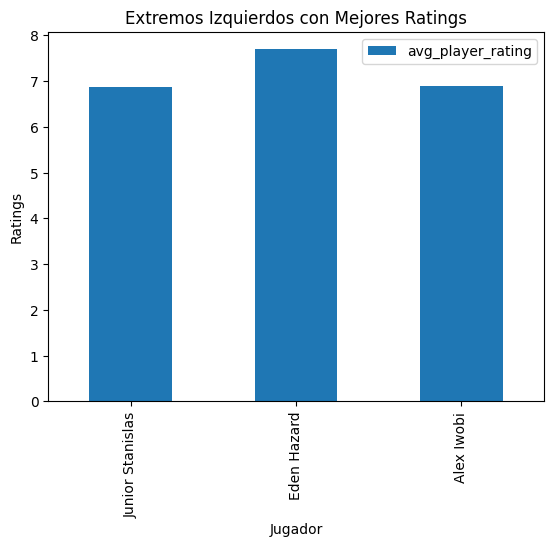

In [0]:
# Se selecciona player_name y avg_player_rating
dfLWFiltrado.createOrReplaceTempView("dfLWFiltrado_sql")
lw_parametro_df = sparkParcial.sql('''SELECT player_name, avg_player_rating FROM dfLWFiltrado_sql''')
#se crea la grafica
lw_parametro_df = lw_parametro_df.toPandas()
gra = lw_parametro_df.plot(x="player_name", y="avg_player_rating", kind="bar")

gra.set_xlabel('Jugador')
gra.set_ylabel('Ratings')
gra.set_title('Extremos Izquierdos con Mejores Ratings')

plt.show()



In [0]:
##se filtra los datos para los jugadores Attacking Midfielder
dfAM = dftodos_clean.filter(dftodos_clean.position == 'AM')

for valor in dfAM.columns:
 dfAM.describe([valor]).show()

+-------+------------------+
|summary|          match_id|
+-------+------------------+
|  count|               148|
|   mean|1190370.2162162163|
| stddev|109.80437400928628|
|    min|           1190177|
|    max|           1190550|
+-------+------------------+

+-------+------------------+
|summary|           team_id|
+-------+------------------+
|  count|               148|
|   mean|30.155405405405407|
| stddev|23.167451023134987|
|    min|                15|
|    max|                31|
+-------+------------------+

+-------+---------+
|summary|team_name|
+-------+---------+
|  count|      148|
|   mean|     NULL|
| stddev|     NULL|
|    min|  Chelsea|
|    max|  Watford|
+-------+---------+

+-------+------------------+
|summary|       team_rating|
+-------+------------------+
|  count|               148|
|   mean| 6.823867694751637|
| stddev|0.3801867677519308|
|    min|         5.8535714|
|    max|         7.8442855|
+-------+------------------+

+-------+---------------------+
|

In [0]:
#se encuentra los promedios de columnas importantes al AM
dfAMAVG = dfAM.groupBy("player_name").agg(sqlfun.avg("player_rating").alias("avg_player_rating"), sqlfun.avg("touches").alias("avg_touches"), sqlfun.avg("fpl_points").alias("avg_fpl_points"), sqlfun.avg("possession_percentage").alias("avg_possession_percentage"))

#se selecciona los jugadores que tengan un rating promedio sobre 6.0
dfAMAVG.createOrReplaceTempView("dfAMAVG_sql")
dfAMFiltrado = sparkParcial.sql('''Select * from dfAMAVG_sql where avg_player_rating>=6.0''')
dfAMFiltrado.count()

9

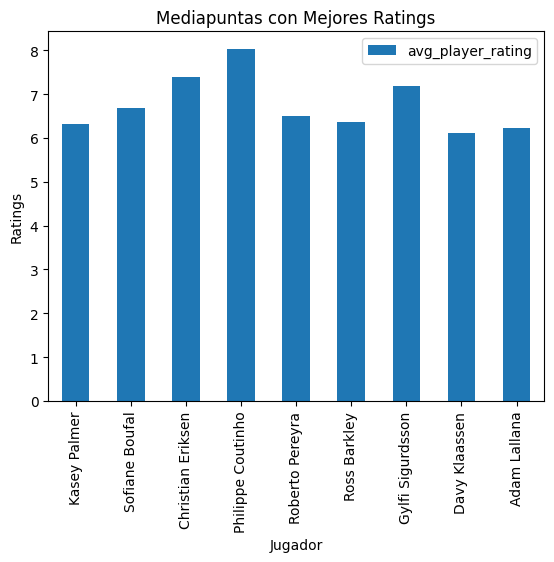

In [0]:
# Se selecciona el nombre del jugador y el avg_player_rating
dfAMFiltrado.createOrReplaceTempView("dfAMFiltrado_sql")
am_parametro_df = sparkParcial.sql('''SELECT player_name, avg_player_rating FROM dfAMFiltrado_sql''')

#se crea la grafica
am_parametro_df = am_parametro_df.toPandas()
gra = am_parametro_df.plot(x="player_name", y="avg_player_rating", kind="bar")

gra.set_xlabel('Jugador')
gra.set_ylabel('Ratings')
gra.set_title('Mediapuntas con Mejores Ratings')

plt.show()

In [0]:
##se filtra los datos para los jugadores Goal Keeper
dfGK = dfMTeam.filter(dftodos_clean.position == 'GK')

for valor in dfGK.columns:
 dfGK.describe([valor]).show()

+-------+---------+
|summary|team_name|
+-------+---------+
|  count|      156|
|   mean|     NULL|
| stddev|     NULL|
|    min|  Arsenal|
|    max|Tottenham|
+-------+---------+

+-------+-------------------+
|summary|   avg(team_rating)|
+-------+-------------------+
|  count|                156|
|   mean|  6.945546839793056|
| stddev|0.03833710791223612|
|    min|  6.780094991025236|
|    max|   6.99623276346879|
+-------+-------------------+

+-------+------------------+
|summary|          match_id|
+-------+------------------+
|  count|               156|
|   mean|1190365.0064102565|
| stddev|115.04363810450897|
|    min|           1190174|
|    max|           1190552|
+-------+------------------+

+-------+-----------------+
|summary|          team_id|
+-------+-----------------+
|  count|              156|
|   mean|25.07051282051282|
| stddev|26.82105869298857|
|    min|               13|
|    max|               30|
+-------+-----------------+

+-------+------------------+
|sum

In [0]:
#se crea una vista de dfGk
dfGK.createOrReplaceTempView("dfGK_sql")
# Se filtra por jugador y su promedio de rating y se compara para ver si es sobre 6.6
dfGKFiltrado = sparkParcial.sql('''
with avg_ratings as (select player_name, AVG(player_rating) as avg_player_rating from dfGK_sql group by player_name)
select player_name, avg_player_rating from avg_ratings where avg_player_rating >= 6.6''')
dfGKFiltrado.count()

7

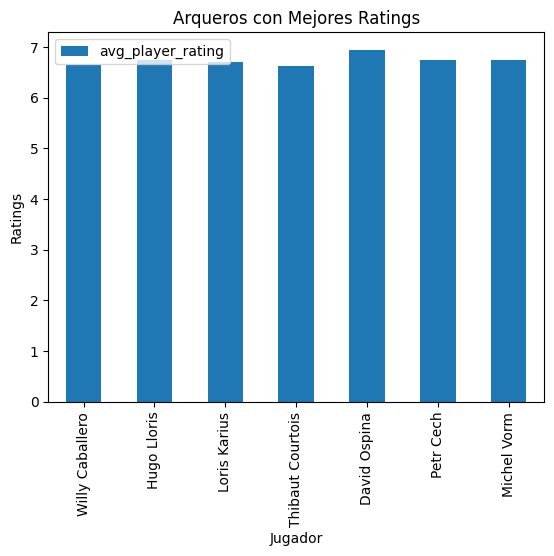

In [0]:
# Se eligen los elementos a graficar
dfGKFiltrado.createOrReplaceTempView("dfGKFiltrado_sql")
gk_parametro_df = sparkParcial.sql('''SELECT * FROM dfGKFiltrado_sql''')
# Se genera la grafica de barras correspondiente
gk_parametro_df = gk_parametro_df.toPandas()
gra = gk_parametro_df.plot(x="player_name", y="avg_player_rating", kind="bar")

gra.set_xlabel('Jugador')
gra.set_ylabel('Ratings')
gra.set_title('Arqueros con Mejores Ratings')

plt.show()

In [0]:
##se filtra los datos para los jugadores RB
dfRB = dftodos_clean.filter(dftodos_clean.position == 'RB')

for valor in dfRB.columns:
 dfRB.describe([valor]).show()


dfRB.createOrReplaceTempView("dfRB_sql")
# Se obtienen los jugadores de la posicion RB con mejores ratings
dfRBFiltrado = sparkParcial.sql('''
WITH avg_ratings AS (SELECT player_name, AVG(player_rating) AS avg_player_rating FROM dfRB_sql GROUP BY player_name)
SELECT player_name, avg_player_rating FROM avg_ratings WHERE avg_player_rating >= 6.75''')
dfRBFiltrado.count()


+-------+------------------+
|summary|          match_id|
+-------+------------------+
|  count|               264|
|   mean|1190364.4128787878|
| stddev| 109.6332287790364|
|    min|           1190176|
|    max|           1190553|
+-------+------------------+

+-------+------------------+
|summary|           team_id|
+-------+------------------+
|  count|               264|
|   mean|120.81818181818181|
| stddev| 88.24006471992585|
|    min|               166|
|    max|                31|
+-------+------------------+

+-------+-----------+
|summary|  team_name|
+-------+-----------+
|  count|        264|
|   mean|       NULL|
| stddev|       NULL|
|    min|Bournemouth|
|    max|    Watford|
+-------+-----------+

+-------+-------------------+
|summary|        team_rating|
+-------+-------------------+
|  count|                264|
|   mean|  6.709756204576204|
| stddev|0.36897088104802034|
|    min|          5.8314285|
|    max|          7.8442855|
+-------+-------------------+

+-----

9

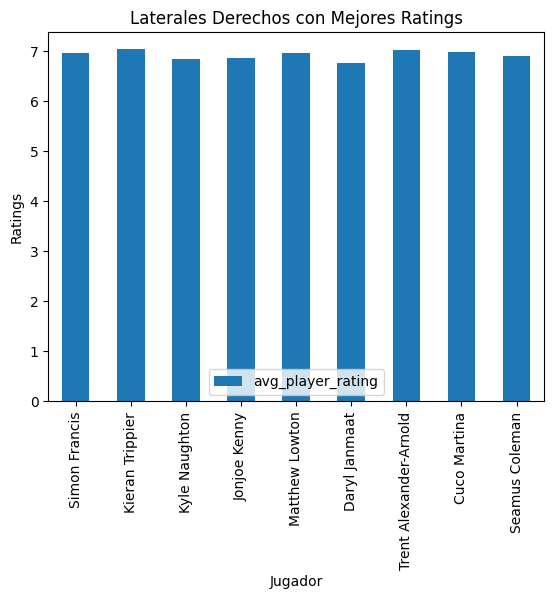

In [0]:
# Se eligen los elementos a graficar
dfRBFiltrado.createOrReplaceTempView("dfRBFiltrado_sql")
rb_parametro_df = sparkParcial.sql('''SELECT * FROM dfRBFiltrado_sql''')
# Se genera la grafica de barras correspondiente
rb_parametro_df = rb_parametro_df.toPandas()
gra=rb_parametro_df.plot(x="player_name", y="avg_player_rating", kind="bar")

gra.set_xlabel('Jugador')
gra.set_ylabel('Ratings')
gra.set_title('Laterales Derechos con Mejores Ratings')

plt.show()



In [0]:

# #se filtra los datos para los jugadores RW
dfRW = dftodos_clean.filter(dftodos_clean.position == 'RW')

for valor in dfRW.columns:
 dfRW.describe([valor]).show()


dfRW.createOrReplaceTempView("dfRW_sql")
# Se obtienen los jugadores de la posicion RW con mejores ratings
dfRWFiltrado = sparkParcial.sql('''
WITH avg_ratings AS (SELECT player_name, AVG(player_rating) AS avg_player_rating FROM dfRW_sql GROUP BY player_name)
SELECT player_name, avg_player_rating FROM avg_ratings WHERE avg_player_rating >= 6.75''')
dfRWFiltrado.count()

+-------+------------------+
|summary|          match_id|
+-------+------------------+
|  count|               360|
|   mean|1190363.5277777778|
| stddev|110.29461334628687|
|    min|           1190174|
|    max|           1190553|
+-------+------------------+

+-------+------------------+
|summary|           team_id|
+-------+------------------+
|  count|               360|
|   mean|101.70277777777778|
| stddev|  91.0917869035816|
|    min|                13|
|    max|                31|
+-------+------------------+

+-------+---------+
|summary|team_name|
+-------+---------+
|  count|      360|
|   mean|     NULL|
| stddev|     NULL|
|    min|  Arsenal|
|    max|Tottenham|
+-------+---------+

+-------+------------------+
|summary|       team_rating|
+-------+------------------+
|  count|               360|
|   mean| 6.767411507500542|
| stddev|0.3802268742239008|
|    min|         5.9614286|
|    max|         7.8442855|
+-------+------------------+

+-------+---------------------+
|

3

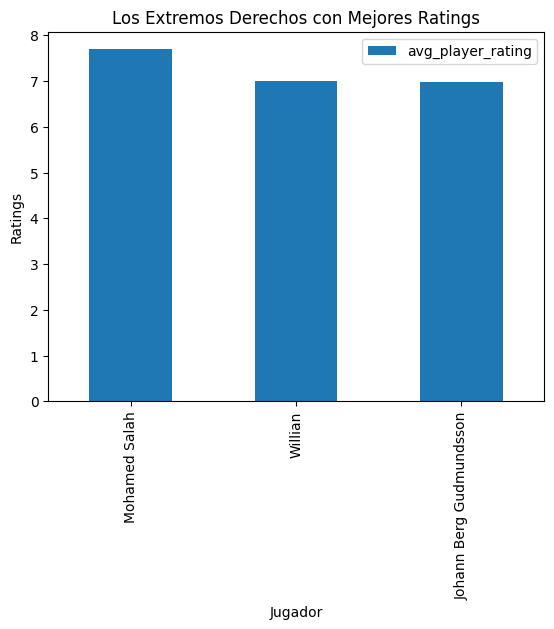

In [0]:
# Se eligen los elementos a graficar
dfRWFiltrado.createOrReplaceTempView("dfRWFiltrado_sql")
rw_parametro_df = sparkParcial.sql('''SELECT * FROM dfRWFiltrado_sql''')
# Se genera la grafica de barras correspondiente
rw_parametro_df = rw_parametro_df.toPandas()
gra = rw_parametro_df.plot(x="player_name", y="avg_player_rating", kind="bar")

gra.set_xlabel('Jugador')
gra.set_ylabel('Ratings')
gra.set_title('Los Extremos Derechos con Mejores Ratings')

plt.show()


In [0]:
##se filtra los datos para los jugadores RM y LM
dfRM = dftodos_clean.filter((dftodos_clean.position == 'RM') | (dftodos_clean.position == 'LM'))

dfRM.show(10)

dfRM.createOrReplaceTempView("dfRM_sql")
# Se obtienen los jugadores de la posicion RM con mejores ratings
dfRMFiltrado = sparkParcial.sql('''WITH avg_ratings AS (SELECT player_name, AVG(player_rating) AS avg_player_rating FROM dfRM_sql GROUP BY player_name)
    SELECT player_name, avg_player_rating FROM avg_ratings WHERE avg_player_rating >= 6.5''')
dfRMFiltrado.count()

+--------+-------+-----------+-----------+---------------------+----------+---------------+-------------+-------+---------+-------------+---------------------+--------------------+-------------+---------------+-------+-----+---------------+-----+-----+-----------+-----------+-------------+--------+------------+-------+--------------------+------------+-----------+----+----+---+----+----+---+----------+---+---+---+---+---+---+---+---+---+---+---+---+-------------+-----------+---+--------+------------+------------+----------+---------+-------+----------+------+-----------+-----------+-------+-------+--------+-----------+
|match_id|team_id|  team_name|team_rating|possession_percentage|total_pass|shot_off_target|total_offside|  match|player_id|  player_name|player_position_value|player_position_info|player_rating|good_high_claim|touches|saves|formation_place|fouls|goals|goal_assist|yellow_card|second_yellow|red_card|penalty_save| Season|            DateTime|    HomeTeam|   AwayTeam|FTHG|FT

3

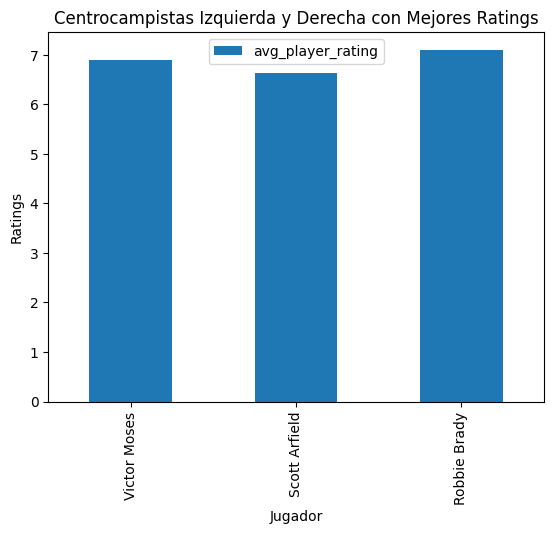

In [0]:
# Se eligen los elementos a graficar
dfRMFiltrado.createOrReplaceTempView("dfRMFiltrado_sql")
rm_parametro_df = sparkParcial.sql('''SELECT * FROM dfRMFiltrado_sql''')
# Se genera la grafica de barras correspondiente
rm_parametro_df = rm_parametro_df.toPandas()
gra = rm_parametro_df.plot(x="player_name", y="avg_player_rating", kind="bar")

gra.set_xlabel('Jugador')
gra.set_ylabel('Ratings')
gra.set_title('Centrocampistas Izquierda y Derecha con Mejores Ratings')

plt.show()


In [0]:
##se filtra los datos para los jugadores CF
dfCF = dftodos_clean.filter(dftodos_clean.position == 'CF')
for valor in dfCF.columns:
 dfCF.describe([valor]).show()

+-------+------------------+
|summary|          match_id|
+-------+------------------+
|  count|               656|
|   mean|1190366.5533536586|
| stddev|113.44146106241402|
|    min|           1190174|
|    max|           1190553|
+-------+------------------+

+-------+------------------+
|summary|           team_id|
+-------+------------------+
|  count|               656|
|   mean|109.67835365853658|
| stddev|  91.4661505204296|
|    min|                13|
|    max|                30|
+-------+------------------+

+-------+--------------------+
|summary|           team_name|
+-------+--------------------+
|  count|                 656|
|   mean|                NULL|
| stddev|                NULL|
|    min|             Arsenal|
|    max|West Bromwich Albion|
+-------+--------------------+

+-------+-------------------+
|summary|        team_rating|
+-------+-------------------+
|  count|                656|
|   mean| 6.7150105237960815|
| stddev|0.37003536816238763|
|    min|       

In [0]:
# Se eligen los elementos a graficar
dfCF.createOrReplaceTempView("dfCF_sql")
# Se obtienen los jugadores de la posicion CF con mejores ratings
dfCFFiltrado = sparkParcial.sql('''
WITH avg_ratings AS (SELECT player_name, AVG(player_rating) AS avg_player_rating FROM dfCF_sql GROUP BY player_name)
SELECT player_name, avg_player_rating FROM avg_ratings WHERE avg_player_rating >= 6.56''')
dfCFFiltrado.count()

8

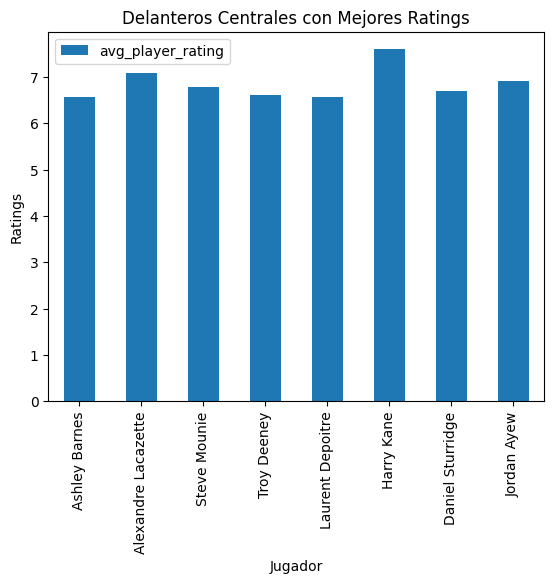

In [0]:
# Se eligen los elementos a graficar
dfCFFiltrado.createOrReplaceTempView("dfCFFiltrado_sql")
cf_parametro_df = sparkParcial.sql('''SELECT * FROM dfCFFiltrado_sql''')
# Se genera la grafica de barras correspondiente
cf_parametro_df = cf_parametro_df.toPandas()
gra = cf_parametro_df.plot(x="player_name", y="avg_player_rating", kind="bar")
gra.set_xlabel('Jugador')
gra.set_ylabel('Ratings')
gra.set_title('Delanteros Centrales con Mejores Ratings')

plt.show()

In [0]:
##se filtra los datos para los jugadores CM
dfCM = dftodos_clean.filter(dftodos_clean.position == 'CM')
for valor in dfCM.columns:
 dfCM.describe([valor]).show()

+-------+------------------+
|summary|          match_id|
+-------+------------------+
|  count|               666|
|   mean|1190357.1471471472|
| stddev|111.86402580831275|
|    min|           1190174|
|    max|           1190553|
+-------+------------------+

+-------+------------------+
|summary|           team_id|
+-------+------------------+
|  count|               666|
|   mean|105.87087087087087|
| stddev| 89.37240575041263|
|    min|                13|
|    max|                31|
+-------+------------------+

+-------+---------+
|summary|team_name|
+-------+---------+
|  count|      666|
|   mean|     NULL|
| stddev|     NULL|
|    min|  Arsenal|
|    max|  Watford|
+-------+---------+

+-------+-------------------+
|summary|        team_rating|
+-------+-------------------+
|  count|                666|
|   mean|  6.748157115311952|
| stddev|0.38588165384706863|
|    min|          5.8314285|
|    max|          7.8442855|
+-------+-------------------+

+-------+---------------

In [0]:
# Se eligen los elementos a graficar
dfCM.createOrReplaceTempView("dfCM_sql")
# Se obtienen los jugadores de la posicion CM con mejores ratings
dfCMFiltrado = sparkParcial.sql('''WITH avg_ratings AS (SELECT player_name, AVG(player_rating) AS avg_player_rating
    FROM dfCM_sql GROUP BY player_name)
    SELECT player_name, avg_player_rating FROM avg_ratings WHERE avg_player_rating >= 6.69''')
dfCMFiltrado.count()

13

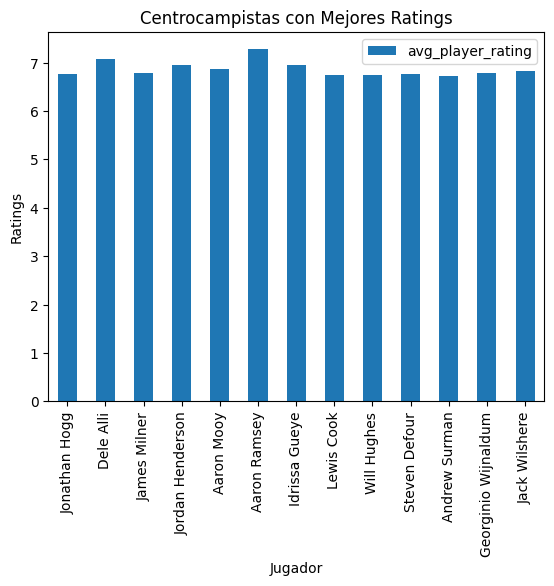

In [0]:
# Se eligen los elementos a graficar
dfCMFiltrado.createOrReplaceTempView("dfCMFiltrado_sql")
cm_parametro_df = sparkParcial.sql('''SELECT * FROM dfCMFiltrado_sql''')
# Se genera la grafica de barras correspondiente
cm_parametro_df = cm_parametro_df.toPandas()
gra = cm_parametro_df.plot(x="player_name", y="avg_player_rating", kind="bar")
gra.set_xlabel('Jugador')
gra.set_ylabel('Ratings')
gra.set_title('Centrocampistas con Mejores Ratings')

plt.show()

In [0]:
##se filtra los datos para los jugadores LB
dfLB = dftodos_clean.filter(dftodos_clean.position == 'LB')

dfLB.createOrReplaceTempView("dfLB_sql")
# Se obtienen los jugadores de la posicion LB con mejores ratings
dfLBFiltrado = sparkParcial.sql('''
WITH avg_ratings AS (SELECT player_name, AVG(player_rating) AS avg_player_rating FROM dfLB_sql GROUP BY player_name)
SELECT player_name, avg_player_rating FROM avg_ratings WHERE avg_player_rating >= 6.75''')
dfLBFiltrado.count()

7

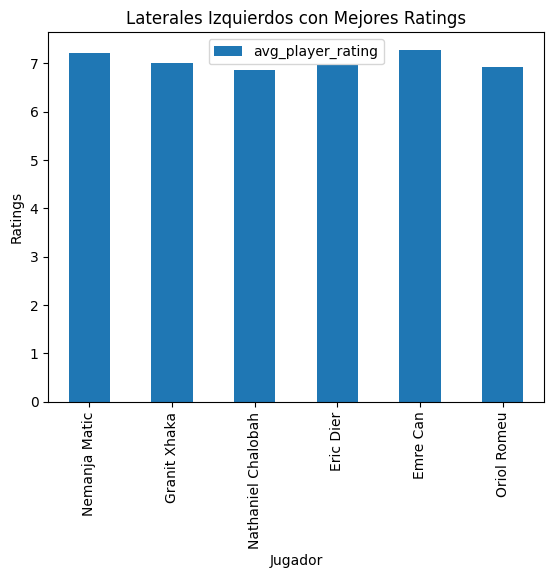

In [0]:
# Se eligen los elementos a graficar
dfLBFiltrado.createOrReplaceTempView("dfLBFiltrado_sql")
lb_parametro_df = sparkParcial.sql('''SELECT * FROM dfLBFiltrado_sql''')
# Se genera la grafica de barras correspondiente
lb_parametro_df = lb_parametro_df.toPandas()

gra = dm_parametro_df.plot(x="player_name", y="avg_player_rating", kind="bar")
gra.set_xlabel('Jugador')
gra.set_ylabel('Ratings')
gra.set_title('Laterales Izquierdos con Mejores Ratings')

plt.show()

In [0]:
##se filtra los datos para los jugadores DM
dfDM = dftodos_clean.filter(dftodos_clean.position == 'DM')

dfDM.createOrReplaceTempView("dfDM_sql")
# Se obtienen los jugadores de la posicion DM con mejores ratings
dfDMFiltrado = sparkParcial.sql('''
WITH avg_ratings AS (SELECT player_name, AVG(player_rating) AS avg_player_rating FROM dfDM_sql GROUP BY player_name)
SELECT player_name, avg_player_rating FROM avg_ratings WHERE avg_player_rating >= 6.75''')
dfDMFiltrado.count()

6

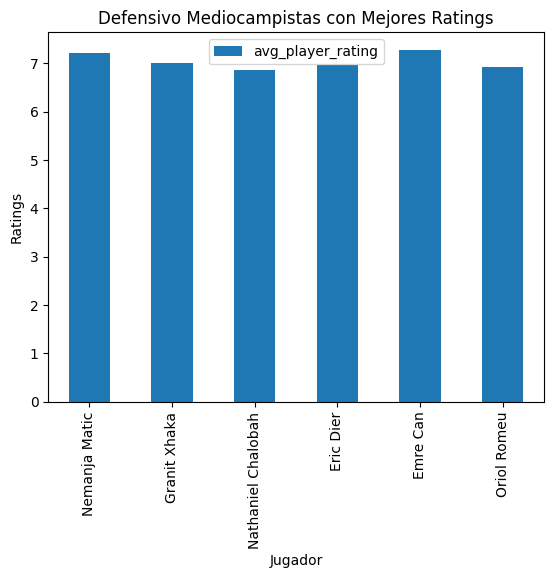

In [0]:
# Se eligen los elementos a graficar
dfDMFiltrado.createOrReplaceTempView("dfLDMFiltrado_sql")
dm_parametro_df = sparkParcial.sql('''SELECT * FROM dfLDMFiltrado_sql''')
# Se genera la grafica de barras correspondiente
dm_parametro_df = dm_parametro_df.toPandas()

gra = dm_parametro_df.plot(x="player_name", y="avg_player_rating", kind="bar")
gra.set_xlabel('Jugador')
gra.set_ylabel('Ratings')
gra.set_title('Defensivo Mediocampistas con Mejores Ratings')

plt.show()

In [0]:
##se filtra los datos para los jugadores SS
dfSS = dftodos_clean.filter(dftodos_clean.position == 'SS')
for valor in dfSS.columns:
 dfSS.describe([valor]).show()

+-------+------------------+
|summary|          match_id|
+-------+------------------+
|  count|               133|
|   mean|1190360.2857142857|
| stddev|114.05305593056171|
|    min|           1190178|
|    max|           1190553|
+-------+------------------+

+-------+-----------------+
|summary|          team_id|
+-------+-----------------+
|  count|              133|
|   mean|67.32330827067669|
| stddev|66.73551924100366|
|    min|              183|
|    max|               31|
+-------+-----------------+

+-------+-----------+
|summary|  team_name|
+-------+-----------+
|  count|        133|
|   mean|       NULL|
| stddev|       NULL|
|    min|Bournemouth|
|    max|  Liverpool|
+-------+-----------+

+-------+------------------+
|summary|       team_rating|
+-------+------------------+
|  count|               133|
|   mean| 6.759277013907755|
| stddev|0.3888637978870432|
|    min|         5.9614286|
|    max|         7.8442855|
+-------+------------------+

+-------+---------------

In [0]:
##se filtra los datos para los jugadores SS
dfSS = dftodos_clean.filter(dftodos_clean.position == 'SS')

dfSS.createOrReplaceTempView("dfSS_sql")
# Se obtienen los jugadores de la posicion SS con mejores ratings
dfSSFiltrado = sparkParcial.sql('''
WITH avg_ratings AS (SELECT player_name, AVG(player_rating) AS avg_player_rating FROM dfSS_sql GROUP BY player_name)
SELECT player_name, avg_player_rating FROM avg_ratings WHERE avg_player_rating >= 6.0''')
dfSSFiltrado.count()

4

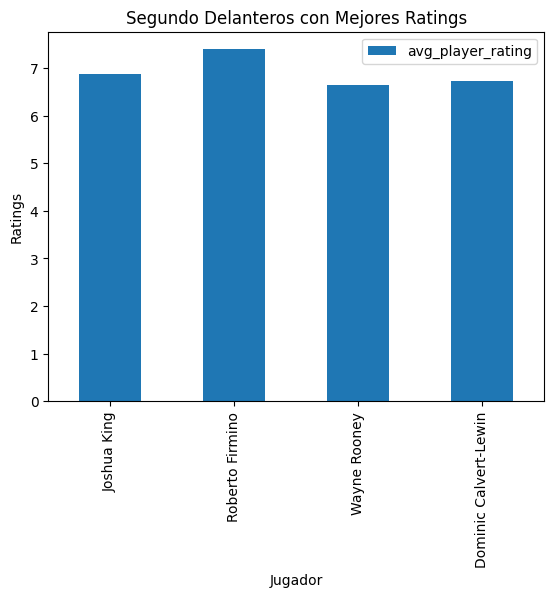

In [0]:
# Se eligen los elementos a graficar
dfSSFiltrado.createOrReplaceTempView("dfLSSFiltrado_sql")
ss_parametro_df = sparkParcial.sql('''SELECT * FROM dfLSSFiltrado_sql''')
# Se genera la grafica de barras correspondiente
ss_parametro_df = ss_parametro_df.toPandas()

gra = ss_parametro_df.plot(x="player_name", y="avg_player_rating", kind="bar")
gra.set_xlabel('Jugador')
gra.set_ylabel('Ratings')
gra.set_title('Segundo Delanteros con Mejores Ratings')

plt.show()

and player_rating>=6.75 and yellow_card<1.0 and second_yellow<1.0 and red_card<1.0

In [0]:
##se generan las graficas de los jugadores con mejores fpl_points y fpl_values con un maximo de 27 años
dftodos_clean.createOrReplaceTempView("dftodos_clean_sql")

dfPPAFiltrado = sparkParcial.sql('''with avg_points as(Select player_name, avg(fpl_points) as avg_fpl_points, age from dftodos_clean_sql group by player_name, age) Select player_name, avg_fpl_points,age from avg_points where avg_fpl_points >= 73.69 and age<=27''')
dfVPAFiltrado = sparkParcial.sql('''with avg_points as(Select player_name, avg(fpl_value) as avg_fpl_value, age from dftodos_clean_sql group by player_name, age) Select player_name, avg_fpl_value,age from avg_points where avg_fpl_value >= 5.73 and age<=27''')
dfVPAFiltrado.count()


35

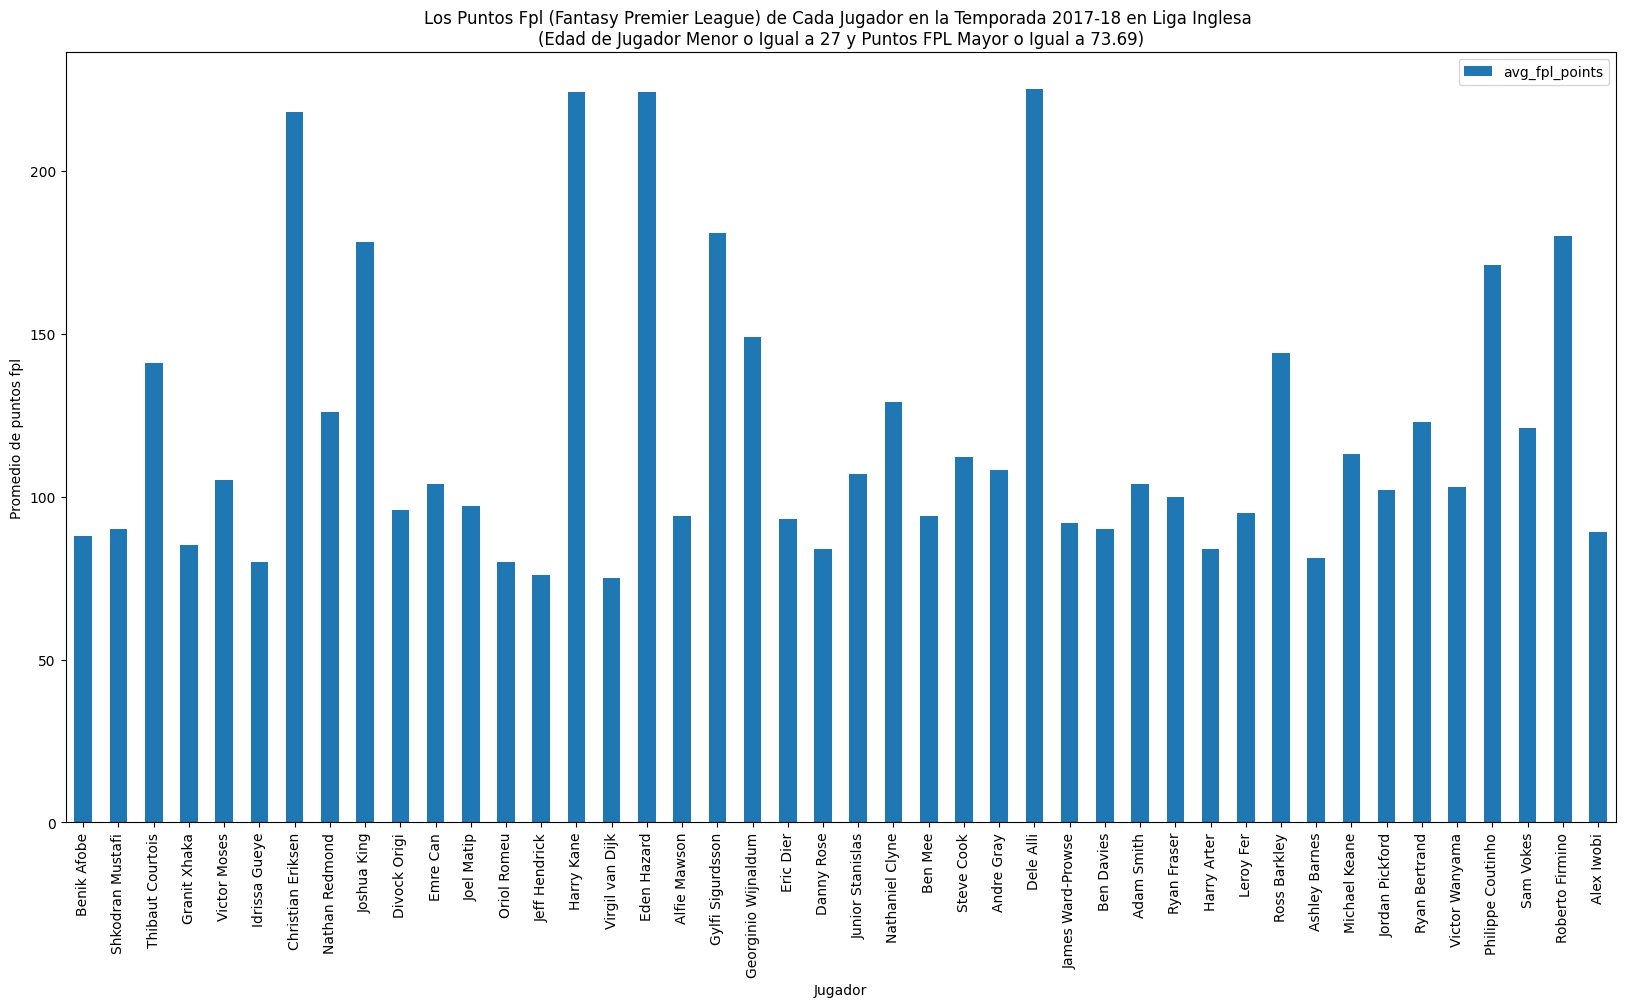

In [0]:
##se generan las graficas de los jugadores con mejores fpl_points
dfPPAFiltrado.createOrReplaceTempView("dfLPPAFiltrado_sql")
ppa_parametro_df = sparkParcial.sql('''SELECT * FROM dfLPPAFiltrado_sql''')
ppa_parametro_df = ppa_parametro_df.toPandas()

gra13 = ppa_parametro_df.plot(figsize=(20, 10),x="player_name", y="avg_fpl_points", kind="bar")
gra13.set_xlabel('Jugador')
gra13.set_ylabel('Promedio de puntos fpl')
gra13.set_title('Los Puntos Fpl (Fantasy Premier League) de Cada Jugador en la Temporada 2017-18 en Liga Inglesa \n(Edad de Jugador Menor o Igual a 27 y Puntos FPL Mayor o Igual a 73.69)')

plt.show()

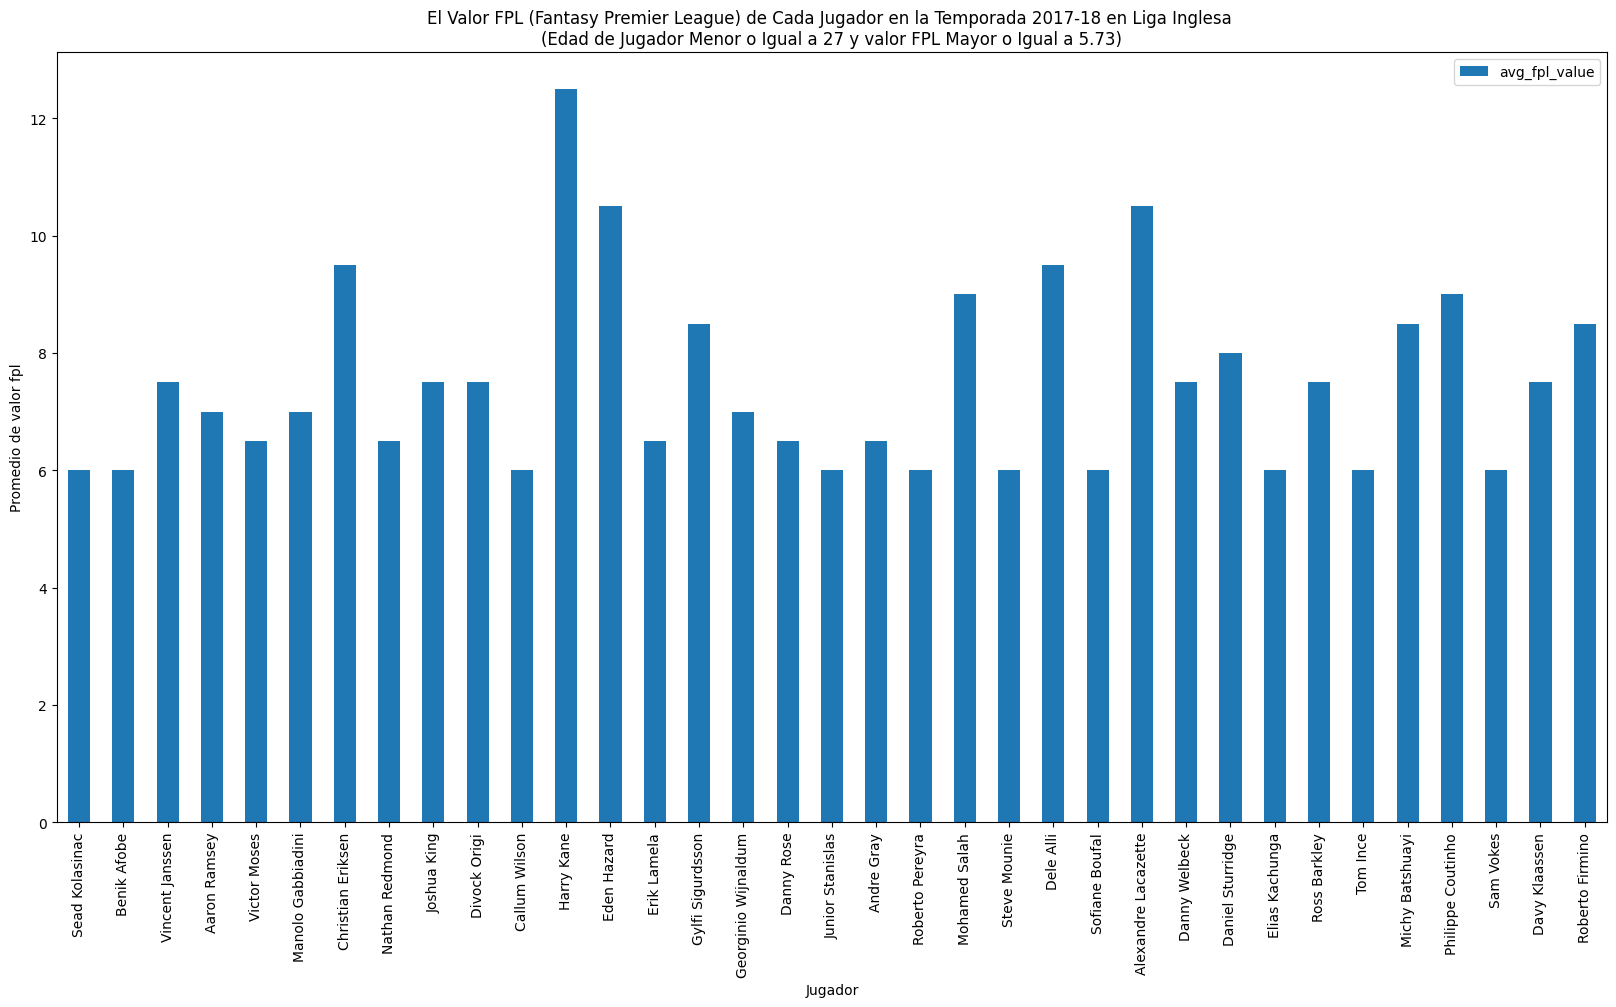

In [0]:
#Se generan las graficas de los jugadores con mejores fpl_values
dfVPAFiltrado.createOrReplaceTempView("dfLVPAFiltrado_sql")
vpa_parametro_df = sparkParcial.sql('''SELECT * FROM dfLVPAFiltrado_sql''')
vpa_parametro_df = vpa_parametro_df.toPandas()

gra14 = vpa_parametro_df.plot(figsize=(20, 10),x="player_name", y="avg_fpl_value", kind="bar")
gra14.set_xlabel('Jugador')
gra14.set_ylabel('Promedio de valor fpl')
gra14.set_title('El Valor FPL (Fantasy Premier League) de Cada Jugador en la Temporada 2017-18 en Liga Inglesa \n(Edad de Jugador Menor o Igual a 27 y valor FPL Mayor o Igual a 5.73)')

plt.show()

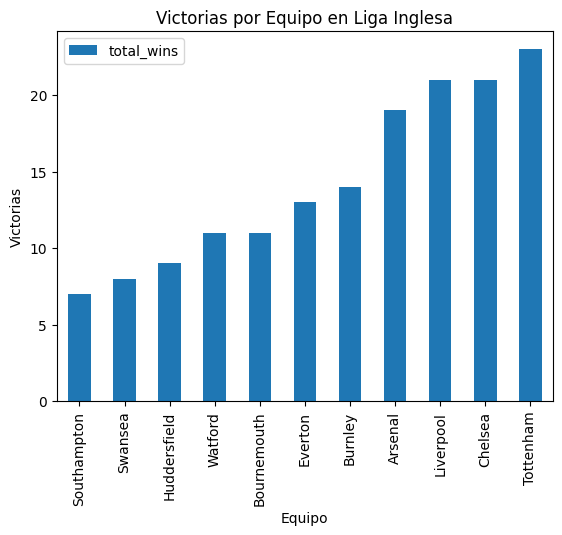

In [0]:
#se encuentra la cantidadd e veces que cada equipo ha ganado y se grafica los resultados
dfBTeams = sparkParcial.sql('''Select team_name, count(*) as total_wins from(select distinct match_id,team_name,HomeTeam,AwayTeam,FTR from dftodos_clean_sql where (FTR = 'H' and team_name = HomeTeam)or (FTR = 'A' and team_name = AwayTeam)) a group by team_name order by total_wins''')
dfBTeams.createOrReplaceTempView("dfBTeams_sql")
dfBTeams = sparkParcial.sql('''Select * from dfBTeams_sql''')
dfBTeams = dfBTeams.toPandas()
gra15 = dfBTeams.plot(x="team_name", y="total_wins", kind="bar")
gra15.set_xlabel('Equipo')
gra15.set_ylabel('Victorias')
gra15.set_title('Victorias por Equipo en Liga Inglesa')
plt.show()